In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [2]:
import torch
import torch.nn as nn

class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x),2*x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.chebyshevkan1 = ChebyshevKANLayer(2, 8, 8)
        self.chebyshevkan2 = ChebyshevKANLayer(8, 16, 4)
        self.chebyshevkan3 = ChebyshevKANLayer(16, 1, 4)

    def forward(self, x):
        x = self.chebyshevkan1(x)
        x = self.chebyshevkan2(x)
        x = self.chebyshevkan3(x)
        return x

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)


In [4]:
model = Model()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 2000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = model(x_train_2d)
    loss_chebyshev = criterion(outputs_cheby, y_train_2d)
    loss_chebyshev.backward()
    optimizer_cheby.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Model Loss: {loss_chebyshev.item():.4f}')

# Test the model
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_model = model(x_test_2d).detach().numpy()

Epoch 1/2000, Model Loss: 2.7264
Epoch 101/2000, Model Loss: 0.1563
Epoch 201/2000, Model Loss: 0.1363
Epoch 301/2000, Model Loss: 0.1120
Epoch 401/2000, Model Loss: 0.1005
Epoch 501/2000, Model Loss: 0.0914
Epoch 601/2000, Model Loss: 0.0838
Epoch 701/2000, Model Loss: 0.0793
Epoch 801/2000, Model Loss: 0.0778
Epoch 901/2000, Model Loss: 0.0801
Epoch 1001/2000, Model Loss: 0.0734
Epoch 1101/2000, Model Loss: 0.0735
Epoch 1201/2000, Model Loss: 0.0692
Epoch 1301/2000, Model Loss: 0.0753
Epoch 1401/2000, Model Loss: 0.0698
Epoch 1501/2000, Model Loss: 0.0665
Epoch 1601/2000, Model Loss: 0.0678
Epoch 1701/2000, Model Loss: 0.0753
Epoch 1801/2000, Model Loss: 0.0709
Epoch 1901/2000, Model Loss: 0.0659


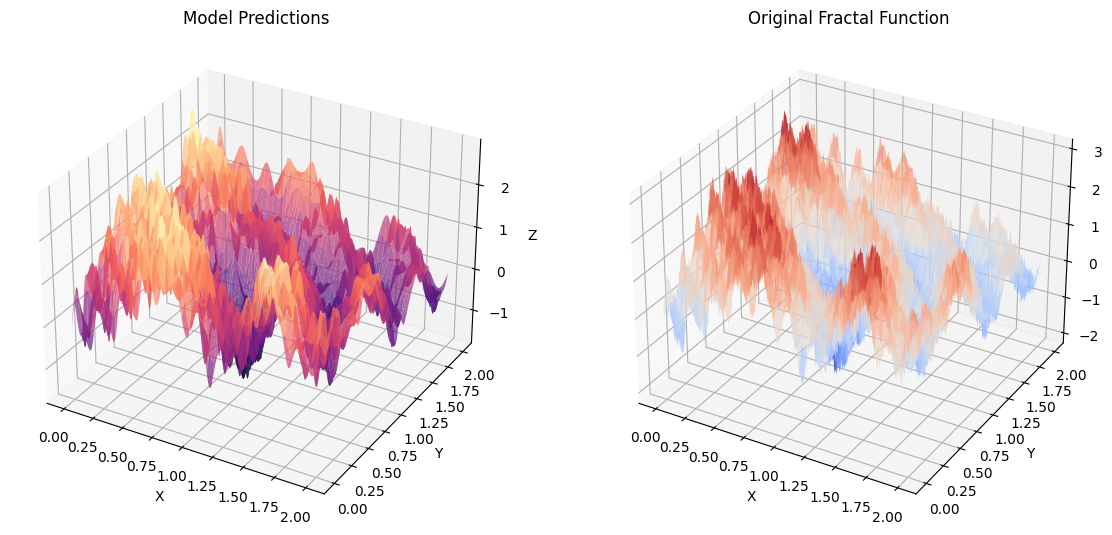

In [5]:
fig = plt.figure(figsize=(14, 7))

ax2 = fig.add_subplot(121, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_model.reshape(X_test.shape), cmap='magma', alpha=0.7, label='Model Prediction')
ax2.set_title('Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(122, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()

In [6]:
# Define the seed function
def seed_function(x, y):
    return 1 / np.sqrt(x**2 + y**2 + 1) + np.sin(x**2 + y**2)

# Define the fractal-like 2D function
def fractal_function(x, y, alpha=0.7, b=0.001, iterations=5):
    z = seed_function(x, y)
    for _ in range(iterations):
        noise = np.random.uniform(-b, b, x.shape)
        z = z + alpha * noise
    return z

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

In [7]:
# Train the model
epochs = 1000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = model(x_train_2d)
    loss_chebyshev = criterion(outputs_cheby, y_train_2d)
    loss_chebyshev.backward()
    optimizer_cheby.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Model Loss: {loss_chebyshev.item():.4f}')

# Test the model
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_model = model(x_test_2d).detach().numpy()

Epoch 1/1000, Model Loss: 1.0073
Epoch 101/1000, Model Loss: 0.0040
Epoch 201/1000, Model Loss: 0.0017
Epoch 301/1000, Model Loss: 0.0010
Epoch 401/1000, Model Loss: 0.0007
Epoch 501/1000, Model Loss: 0.0006
Epoch 601/1000, Model Loss: 0.0004
Epoch 701/1000, Model Loss: 0.0003
Epoch 801/1000, Model Loss: 0.0008
Epoch 901/1000, Model Loss: 0.0003


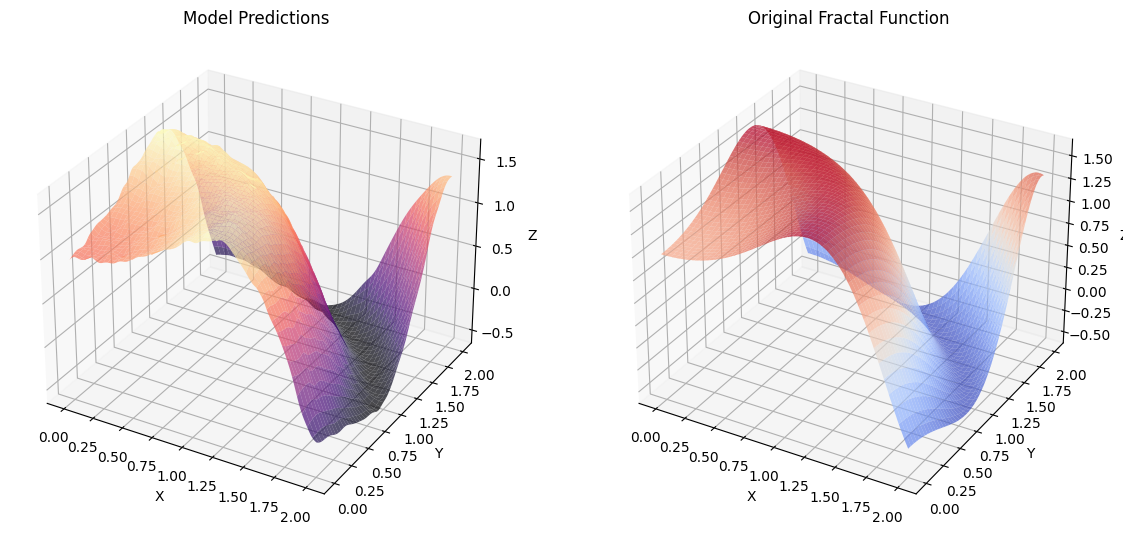

In [8]:
# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 7))

ax2 = fig.add_subplot(121, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_model.reshape(X_test.shape), cmap='magma', alpha=0.7, label='Model Prediction')
ax2.set_title('Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(122, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()